In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from plotly.subplots import make_subplots
from scipy.stats import t

In [13]:
station = "Bats"

In [14]:
data = xr.load_dataset(f"./products/{station}_obs_filtered.zarr", engine="zarr")
data

<xarray.Dataset> Size: 13kB
Dimensions:    (time: 529, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * time       (time) datetime64[ns] 4kB 1995-05-10 1995-05-11 ... 2022-12-13
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB nan ... 0.362
    night      (time, latitude, longitude, layer) float64 4kB 1.108 nan ... 1.11
Attributes:
    creation date:  2024-10-13T20:03:40.209673
    layer:          epipelagic
    station:        Bats

## Number of samples


In [15]:
# Calculer les comptes mensuels
day_counts_month = data.groupby("time.month").count().day[:, 0, 0, 0]
night_counts_month = data.groupby("time.month").count().night[:, 0, 0, 0]

day_counts_month_cumsum = day_counts_month.cumsum()
night_counts_month_cumsum = night_counts_month.cumsum()

# Calculer les comptes annuels
day_counts_year = data.groupby("time.year").count().day[:, 0, 0, 0]
night_counts_year = data.groupby("time.year").count().night[:, 0, 0, 0]

day_counts_year_cumsum = day_counts_year.cumsum()
night_counts_year_cumsum = night_counts_year.cumsum()

# Créer la figure avec des subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Yearly Data", "Monthly Data"))

# Ajouter les traces pour les données annuelles
fig.add_trace(go.Scatter(x=day_counts_year["year"], y=day_counts_year, mode="lines+markers", name="Day"), row=1, col=1)
fig.add_trace(
    go.Scatter(x=night_counts_year["year"], y=night_counts_year, mode="lines+markers", name="Night"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=day_counts_year_cumsum["year"],
        y=day_counts_year_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_year_cumsum["year"],
        y=night_counts_year_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)

# Ajouter les traces pour les données mensuelles
fig.add_trace(
    go.Scatter(x=day_counts_month["month"], y=day_counts_month, mode="lines+markers", name="Day"), row=1, col=2
)
fig.add_trace(
    go.Scatter(x=night_counts_month["month"], y=night_counts_month, mode="lines+markers", name="Night"), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=day_counts_month_cumsum["month"],
        y=day_counts_month_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_month_cumsum["month"],
        y=night_counts_month_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)

# Mettre à jour la mise en page avec le menu déroulant
fig.update_layout(
    title=f"Nb of samples during day and night by year and month at {station}",
    xaxis_title="Year",
    yaxis_title="Nb of samples",
    legend_title="Legend",
    xaxis={"showgrid": True},
    yaxis={"showgrid": True},
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, True, False, False, True, True, False, False]}],
                    "label": "Non-Cumulative",
                    "method": "update",
                },
                {
                    "args": [{"visible": [False, False, True, True, False, False, True, True]}],
                    "label": "Cumulative",
                    "method": "update",
                },
            ],
            "direction": "down",
            "showactive": True,
        }
    ],
)
# wider layout
fig.update_layout(width=1100, height=600)
fig.show()

## Computing the trend


/var/folders/36/grrgsqjd14j4tf6cf5ty4ykh0000gn/T/ipykernel_27588/70799619.py:6: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

/var/folders/36/grrgsqjd14j4tf6cf5ty4ykh0000gn/T/ipykernel_27588/70799619.py:13: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be

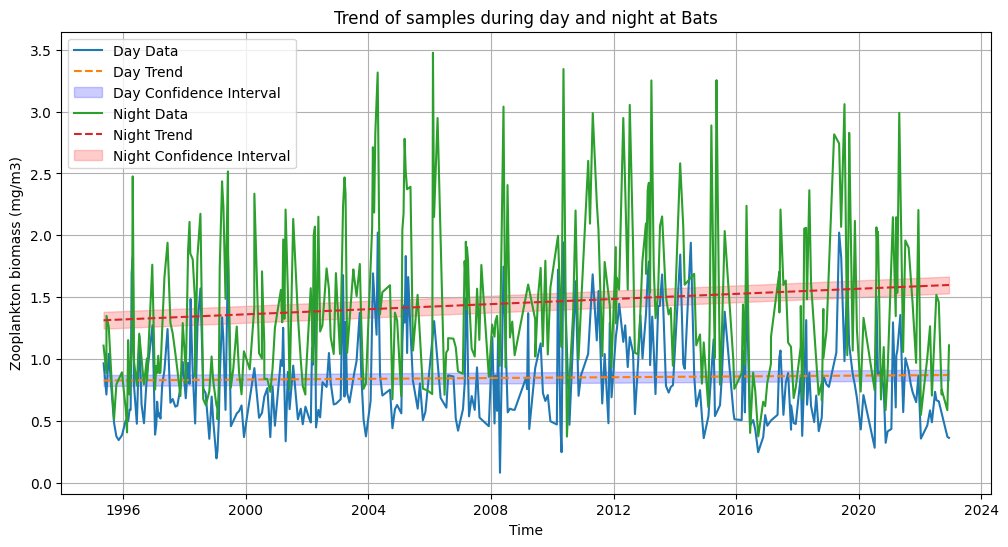

In [16]:
# Extraire les données de jour et de nuit
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

# Extraire les indices de temps en jours
time_indices = (day_data["time"] - day_data["time"][0]).astype("timedelta64[D]").astype(int)

# Ajuster une ligne droite aux données de jour
day_trend = np.polyfit(time_indices, day_data, 1)
day_trend_line = np.polyval(day_trend, time_indices)

# Ajuster une ligne droite aux données de nuit
night_time_indices = (night_data["time"] - night_data["time"][0]).astype("timedelta64[D]").astype(int)
night_trend = np.polyfit(night_time_indices, night_data, 1)
night_trend_line = np.polyval(night_trend, night_time_indices)

# Calculer l'erreur standard des tendances de jour et de nuit
day_std_error = np.std(day_data - day_trend_line) / np.sqrt(len(day_data))
night_std_error = np.std(night_data - night_trend_line) / np.sqrt(len(night_data))

# Définir le niveau de confiance (par exemple, 95%)
confidence_level = 0.95
degrees_freedom_day = len(day_data) - 2
degrees_freedom_night = len(night_data) - 2

# Calculer la valeur critique t pour le niveau de confiance et les degrés de liberté
t_critical_day = t.ppf((1 + confidence_level) / 2, degrees_freedom_day)
t_critical_night = t.ppf((1 + confidence_level) / 2, degrees_freedom_night)

# Calculer l'intervalle de confiance
day_confidence_interval = float(t_critical_day * day_std_error)
night_confidence_interval = float(t_critical_night * night_std_error)

# Tracer les données et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_trend_line, label="Day Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_trend_line - day_confidence_interval,
    day_trend_line + day_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_trend_line, label="Night Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_trend_line - night_confidence_interval,
    night_trend_line + night_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Confidence Interval",
)

plt.legend()
plt.title(f"Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

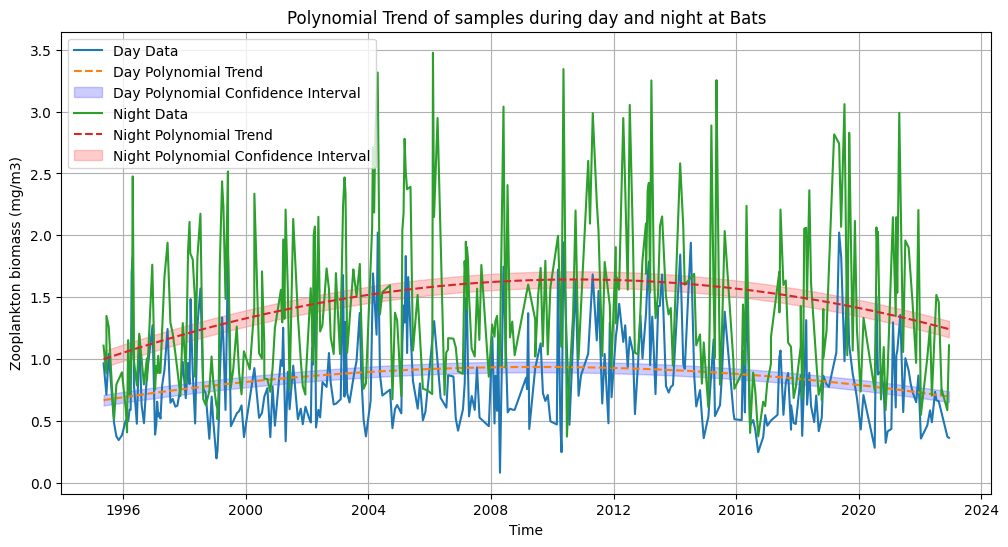

In [17]:
# Ajuster une fonction polynomiale de degré 2 aux données de jour
day_poly_trend = np.polyfit(time_indices, day_data, 2)
day_poly_trend_line = np.polyval(day_poly_trend, time_indices)

# Ajuster une fonction polynomiale de degré 2 aux données de nuit
night_poly_trend = np.polyfit(night_time_indices, night_data, 2)
night_poly_trend_line = np.polyval(night_poly_trend, night_time_indices)

# Calculer l'erreur standard des tendances polynomiales de jour et de nuit
day_poly_std_error = np.std(day_data - day_poly_trend_line) / np.sqrt(len(day_data))
night_poly_std_error = np.std(night_data - night_poly_trend_line) / np.sqrt(len(night_data))

# Calculer l'intervalle de confiance pour les tendances polynomiales
day_poly_confidence_interval = float(t_critical_day * day_poly_std_error)
night_poly_confidence_interval = float(t_critical_night * night_poly_std_error)

# Tracer les données et les intervalles de confiance pour les tendances polynomiales
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_poly_trend_line, label="Day Polynomial Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_poly_trend_line - day_poly_confidence_interval,
    day_poly_trend_line + day_poly_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Polynomial Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_poly_trend_line, label="Night Polynomial Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_poly_trend_line - night_poly_confidence_interval,
    night_poly_trend_line + night_poly_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Polynomial Confidence Interval",
)

plt.legend()
plt.title(f"Polynomial Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Group data by week


In [21]:
grouped_data = xr.Dataset({"day": data.day, "night": data.night})

# Calculer les moyennes mensuelles des données détrendées
grouped_data = grouped_data.groupby("time.week").mean()
grouped_data

# ajouter des nan pour les semaines manquantes
grouped_data = grouped_data.reindex(week=np.arange(1, 53))
grouped_data

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/accessor_dt.py:453: FutureWarning:

dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.



<xarray.Dataset> Size: 1kB
Dimensions:    (latitude: 1, layer: 1, longitude: 1, week: 52)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week, latitude, longitude, layer) float64 416B 0.46 ... nan
    night      (week, latitude, longitude, layer) float64 416B 0.804 ... nan

## Raw data, no smoothing


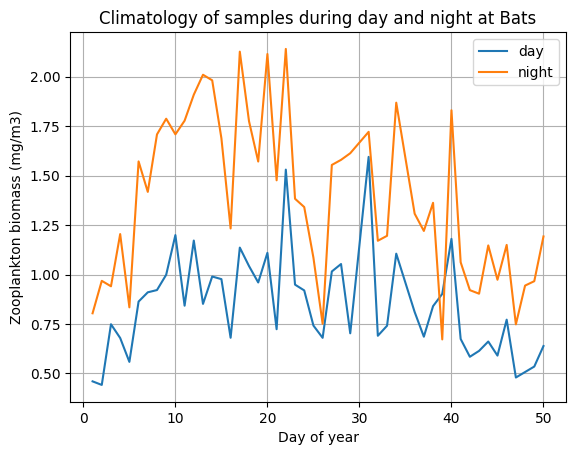

In [22]:
grouped_data.day.dropna("week").plot(label="day")
grouped_data.night.dropna("week").plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Smooth


In [23]:
window_size = 3
pad_size = window_size + 2

# Étendre les données pour simuler la cyclicité
extended_ds = grouped_data.pad(week=(pad_size, pad_size), mode="wrap")

# Appliquer la fenêtre mobile
smoothed = (
    extended_ds.rolling(week=window_size, center=True, min_periods=1)
    .mean()
    .isel(week=slice(pad_size, -pad_size))  # Revenir à la taille originale
)
smoothed

<xarray.Dataset> Size: 1kB
Dimensions:    (latitude: 1, layer: 1, longitude: 1, week: 52)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * week       (week) int64 416B 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    day        (week, latitude, longitude, layer) float64 416B 0.451 ... 0.46
    night      (week, latitude, longitude, layer) float64 416B 0.886 ... 0.804

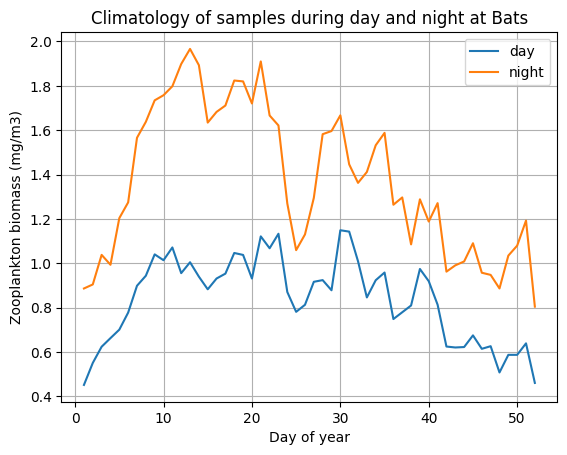

In [24]:
smoothed.day.plot(label="day")
smoothed.night.plot(label="night")
plt.legend()
plt.title(f"Climatology of samples during day and night at {station}")
plt.xlabel("Day of year")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Duplicating observation across the entire time period


In [28]:
value_by_week = smoothed.to_dataframe().reset_index().drop(columns=["latitude", "longitude", "layer"]).set_index("week")
value_by_week.head()

,day,night
week,,
1,0.451000,0.886000
2,0.550222,0.904167
3,0.623270,1.037574
4,0.662103,0.992907
5,0.700298,1.203259


In [29]:
week_by_day = (
    pd.date_range(start=data.indexes["time"][0], end=data.indexes["time"][-1], freq="W")
    .isocalendar()
    .drop(columns=["day", "year"])
)
week_by_day.head()

,week
1995-05-14,19
1995-05-21,20
1995-05-28,21
1995-06-04,22
1995-06-11,23


In [47]:
aggregated_smoothed = week_by_day.join(value_by_week, on="week").drop(columns=["week"])
aggregated_smoothed.index.name = "time"
aggregated_smoothed

,day,night
time,,
1995-05-14,1.037306,1.819972
1995-05-21,0.930917,1.720417
1995-05-28,1.121000,1.910083
1995-06-04,1.067433,1.666267
1995-06-11,1.132804,1.621230
...,...,...
2022-11-13,0.674458,1.090045
2022-11-20,0.613847,0.957045
2022-11-27,0.625659,0.947212


In [48]:
# # Créer une série temporelle pour les tendances de jour et de nuit
# day_trend_series = pd.Series(day_trend_line - day_trend_line[0], index=day_data["time"].values)
# night_trend_series = pd.Series(night_trend_line - night_trend_line[0], index=night_data["time"].values)

# # Réindexer les séries temporelles pour correspondre à l'index de aggregated_smoothed_detrended
# day_trend_interpolated = day_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")
# night_trend_interpolated = night_trend_series.reindex(aggregated_smoothed_detrended.index, method="nearest")

# # Ajouter les tendances interpolées au DataFrame aggregated_smoothed_detrended
# aggregated_smoothed_detrended["day_trend"] = day_trend_interpolated
# aggregated_smoothed_detrended["night_trend"] = night_trend_interpolated

# aggregated_smoothed_detrended.index.name = "time"

# # Afficher le DataFrame avec les tendances ajoutées
# aggregated_smoothed_detrended.head()

In [49]:
climato_observations = xr.Dataset.from_dataframe(aggregated_smoothed)
climato_observations

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1995-05-14 1995-05-21 ... 2022-12-11
Data variables:
    day      (time) float64 12kB 1.037 0.9309 1.121 ... 0.6257 0.5072 0.5867
    night    (time) float64 12kB 1.82 1.72 1.91 1.666 ... 0.9472 0.8861 1.034

## Plot final results


In [50]:
fig = make_subplots(rows=1, cols=1)

# Ajouter les données de jour et de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["day"],  #  + aggregated_smoothed["night_trend"]
        mode="lines",
        name="Day Data with Trend",
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["night"],  # + aggregated_smoothed["night_trend"],
        mode="lines",
        name="Night Data with Trend",
    ),
    row=1,
    col=1,
)

# # Ajouter les tendances de jour et de nuit
# fig.add_trace(
#     go.Scatter(
#         x=aggregated_smoothed.index,
#         y=aggregated_smoothed["day_trend"],
#         mode="lines",
#         name="Day Trend",
#         line=dict(dash="dash"),
#     ),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=aggregated_smoothed.index,
#         y=aggregated_smoothed["night_trend"],
#         mode="lines",
#         name="Night Trend",
#         line=dict(dash="dash"),
#     ),
#     row=1,
#     col=1,
# )

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Evolution des données de jour et de nuit avec tendance à {station}",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

In [51]:
fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données obtenues après traitement de jour
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["day"],  # + aggregated_smoothed["day_trend"],
        mode="lines",
        name="Processed Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# Ajouter les données obtenues après traitement de nuit
fig.add_trace(
    go.Scatter(
        x=aggregated_smoothed.index,
        y=aggregated_smoothed["night"],  # + aggregated_smoothed["night_trend"],
        mode="lines",
        name="Processed Night Data",
    ),
    row=2,
    col=1,
)

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : With Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
)

fig.show()

## Export


In [52]:
climato_observations

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1995-05-14 1995-05-21 ... 2022-12-11
Data variables:
    day      (time) float64 12kB 1.037 0.9309 1.121 ... 0.6257 0.5072 0.5867
    night    (time) float64 12kB 1.82 1.72 1.91 1.666 ... 0.9472 0.8861 1.034

In [53]:
climato_observations = climato_observations.expand_dims(
    latitude=[data.latitude[0]], longitude=[data.longitude[0]], layer=[data.layer[0]]
)
climato_observations = climato_observations.transpose("time", "latitude", "longitude", "layer")

In [55]:
climato_observations.latitude.attrs = data.latitude.attrs
climato_observations.longitude.attrs = data.longitude.attrs
climato_observations.layer.attrs = data.layer.attrs
climato_observations.time.attrs = data.time.attrs
climato_observations.day.attrs = data.day.attrs
climato_observations.night.attrs = data.night.attrs
# climato_observations.day_trend.attrs = {"units": "mg/m3", "long_name": "Day Trend"}
# climato_observations.night_trend.attrs = {"units": "mg/m3", "long_name": "Night Trend"}
climato_observations

<xarray.Dataset> Size: 35kB
Dimensions:    (latitude: 1, longitude: 1, layer: 1, time: 1440)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * longitude  (longitude) float64 8B -64.2
  * layer      (layer) int64 8B 0
  * time       (time) datetime64[ns] 12kB 1995-05-14 1995-05-21 ... 2022-12-11
Data variables:
    day        (time, latitude, longitude, layer) float64 12kB 1.037 ... 0.5867
    night      (time, latitude, longitude, layer) float64 12kB 1.82 ... 1.034

In [56]:
climato_observations.to_zarr(f"./products/{station}_climato.zarr", mode="w")